In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_80896/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Tau 2 Calibration
Once a Tau 1 has been calibrated, we can run an acquisition scan experiment with the adapted measurement\
and determine the appropriate/necessary Tau 2 for max fidelity.\
\
The Experiment will consist of:
1. Tau 1 Duration Max Amp Segment
2. Tau 2 (variable) Duration normal Meas Amp Segment
3. Acquisition Scan across pulse and return results

In [14]:
from helper_funcs.utils import *

tau_1 = 42 * ns
tau_1 = get_closest_multiple_of_16(get_dt_from(tau_1)) * dt

acq_duration_dt = 48
acq_latency_dt = get_closest_multiple_of_16(get_dt_from(320 * ns))

acq_start_sec = 0.0 * ns
acq_end_sec = get_closest_multiple_of_16(get_dt_from(500 * ns)) * dt
acq_size = int((acq_end_sec - acq_start_sec) / (dt * acq_duration_dt))

acq_linspace = np.linspace(acq_start_sec, acq_end_sec, acq_size)
print(f"Tau 2 Calibration, Acq Start: {int(1e3*acq_start_sec / ns)/1e3}ns, Acq End: {int(1e3*acq_end_sec / ns)/1e3}ns, Acq Size: {acq_size}")

Tau 2 Calibration, Acq Start: 0.0ns, Acq End: 501.333ns, Acq Size: 46


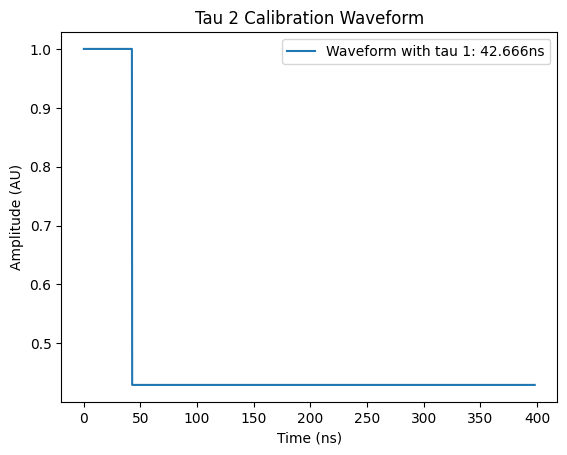

In [18]:
# Tau 2 Calibration Waveform

linspace_len = measure_pulse.duration
ts = np.arange(linspace_len) * measure_pulse.duration * dt / linspace_len

pulse_waveform = np.heaviside(tau_1 - ts, 0.)
pulse_waveform += measure_pulse.amp * np.heaviside(ts - tau_1, 1.)

plt.plot(ts/ns, pulse_waveform, label=f'Waveform with tau 1: {int(1e3*tau_1/ns)/1e3}ns')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (AU)')
plt.title('Tau 2 Calibration Waveform')
plt.legend()
plt.show()

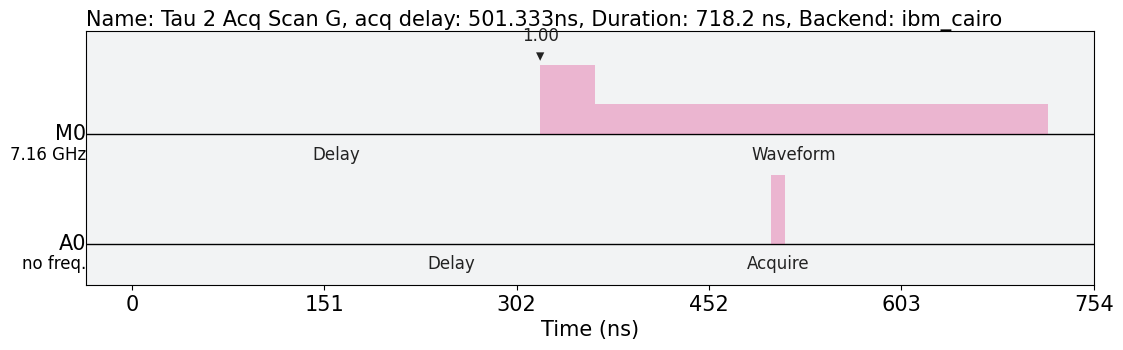

In [23]:
tau_2_exp_g = []
tau_2_exp_e = []

normal_exp_g = []
normal_exp_e = []

for acq_delay_sec in acq_linspace:
    acq_delay_dt = get_closest_multiple_of_16(get_dt_from(acq_delay_sec))

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Tau 2 Acq Scan G, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as tau_2_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)

        pulse.play(pulse.Waveform(pulse_waveform), meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    tau_2_exp_g.append(tau_2_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Tau 2 Acq Scan E, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as tau_2_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(x_pulse, qubit_chan)

        pulse.play(pulse.Waveform(pulse_waveform), meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    tau_2_exp_e.append(tau_2_sched_e)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Normal Acq Scan G, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as normal_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)

        pulse.play(measure_pulse, meas_chan)
        pulse.delay(measure_delay.duration, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    normal_exp_g.append(normal_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Normal Acq Scan E, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}ns'
    ) as normal_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(x_pulse, qubit_chan)

        pulse.play(measure_pulse, meas_chan)
        pulse.delay(measure_delay.duration, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    normal_exp_e.append(normal_sched_e)

tau_2_exp_g[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [26]:
total_exp = tau_2_exp_g + tau_2_exp_e + normal_exp_g + normal_exp_e

acquisition_checker(total_exp)

num_shots = 4096
rep_delay = 499.0 * 1e-6

In [27]:
job_experiment = backend.run(total_exp, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued (None)

KeyboardInterrupt: 

In [28]:
job_1 = provider.backend.retrieve_job('cp9g1np2zy6g008nmt8g')

In [29]:
result_1 = get_results_arr(job_1.result(), qubit)

In [35]:
tau_2_res_g, tau_2_res_e, normal_res_g, normal_res_e = result_1.reshape(4, -1, num_shots)

In [38]:
tau_2_fidelity = get_fidelity(tau_2_res_g, tau_2_res_e)
normal_fidelity = get_fidelity(normal_res_g, normal_res_e)

tau 2 max fid: 99.316
normal max fid: 99.279


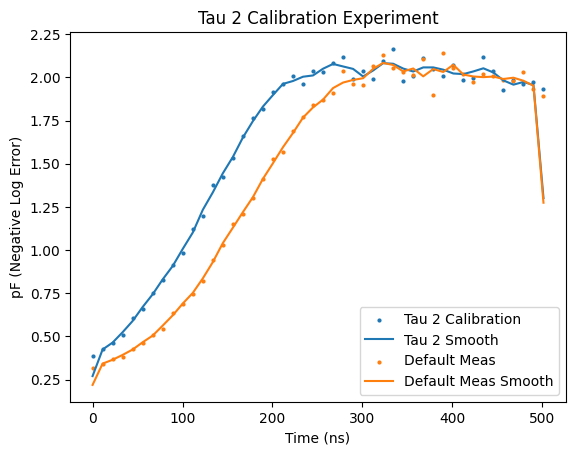

In [41]:
tau_2_pF = -np.log10(1. - tau_2_fidelity)
normal_pF = -np.log10(1. - normal_fidelity)

smooth_tau_2_pF = np.convolve(tau_2_pF, np.ones(3) / 3, mode='same')
smooth_normal_pF = np.convolve(normal_pF, np.ones(3) / 3, mode='same')

print(f"tau 2 max fid: {int(1e5*np.max(tau_2_fidelity))/1e3}")
print(f"normal max fid: {int(1e5*np.max(normal_fidelity))/1e3}")

print(f"tau 2 max smooth: {int(1e5*np.max(tau_2_fidelity))/1e3}")
print(f"normal max smooth: {int(1e5*np.max(normal_fidelity))/1e3}")

plt.scatter(acq_linspace/ns, tau_2_pF, label='Tau 2 Calibration', s=4)
plt.plot(acq_linspace/ns, smooth_tau_2_pF, label='Tau 2 Smooth')
plt.scatter(acq_linspace/ns, normal_pF, label='Default Meas', s=4)
plt.plot(acq_linspace/ns, smooth_normal_pF, label='Default Meas Smooth')
plt.xlabel('Time (ns)')
plt.ylabel('pF (Negative Log Error)')
plt.title('Tau 2 Calibration Experiment')
plt.legend()
plt.show()